In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset,DataLoader
import pytorch_lightning as pl
from DEQLighting import DEQFixedPoint,LinearBlock,anderson,FFM,pictureCoilwithDEQ,CoilwithDEQ
import torch.nn as nn
from DataFidelities.pytorch_radon.radon import IRadon
from DataFidelities.pytorch_radon.filters import HannFilter
import matplotlib.pyplot as plt

In [2]:
def compare_snr(img_test, img_true):
        return 20 * torch.log10(torch.norm(img_true.flatten()) / torch.norm(img_true.flatten() - img_test.flatten()))

In [3]:
fullX=torch.from_numpy(pd.read_csv('data/fullX.csv',index_col=0).to_numpy()).float()
fully=torch.from_numpy(pd.read_csv('data/fully.csv',index_col=0).to_numpy()).float()
gty=torch.from_numpy(pd.read_csv('data/originFullyy.csv',index_col=0).to_numpy()).float()
image=torch.from_numpy(pd.read_csv('data/image.csv',index_col=0).to_numpy()).float()

In [4]:
Cwd=CoilwithDEQ.load_from_checkpoint('experiment/Coil/CoilWithDEQ.ckpt');

{
  "encoder": [],
  "DEQ": [
    {
      "numNeurons": 256,
      "numLayers": 6,
      "skipStride": 2,
      "addx": 5,
      "acti": "relu",
      "lastActi": "relu"
    }
  ],
  "decoder": {
    "extraLayers": [
      {
        "type": "fc",
        "acti": "relu",
        "numNeurons": 256
      },
      {
        "type": "fc",
        "acti": "relu",
        "numNeurons": 256
      },
      {
        "type": "skip",
        "acti": "relu",
        "numNeurons": 256
      },
      {
        "type": "fc",
        "acti": "relu",
        "numNeurons": 256
      }
    ],
    "sigmoidOutput": false
  }
}


In [5]:
pred=Cwd(fullX).detach()
forward_res=Cwd.DEQFixPointLayers[0].forward_res.copy()
del(Cwd)

In [6]:
Cwod=CoilwithDEQ.load_from_checkpoint('experiment/Coil/CoilWithoutDEQ.ckpt');

{
  "encoder": [
    {
      "type": "fc",
      "acti": "relu",
      "numNeurons": 256
    },
    {
      "type": "fc",
      "acti": "relu",
      "numNeurons": 256
    },
    {
      "type": "skip",
      "acti": "relu",
      "numNeurons": 256
    },
    {
      "type": "fc",
      "acti": "relu",
      "numNeurons": 256
    },
    {
      "type": "skip",
      "acti": "relu",
      "numNeurons": 256
    },
    {
      "type": "fc",
      "acti": "relu",
      "numNeurons": 256
    },
    {
      "type": "skip",
      "acti": "relu",
      "numNeurons": 256
    },
    {
      "type": "fc",
      "acti": "relu",
      "numNeurons": 256
    },
    {
      "type": "skip",
      "acti": "relu",
      "numNeurons": 256
    },
    {
      "type": "fc",
      "acti": "relu",
      "numNeurons": 256
    },
    {
      "type": "skip",
      "acti": "relu",
      "numNeurons": 256
    },
    {
      "type": "fc",
      "acti": "relu",
      "numNeurons": 256
    },
    {
      "type": "skip

In [7]:
pred2=Cwod(fullX).detach()
del(Cwod)

In [8]:
sino360PredNoisySNR=compare_snr(pred,fully).detach()
sino360PredGTSNR=compare_snr(pred,gty).detach()
sino360PredNoisySNR2=compare_snr(pred2,fully).detach()
sino360PredGTSNR2=compare_snr(pred2,gty).detach()
sino360NoisyGTSNR=compare_snr(fully,gty).detach()

In [9]:
theta = torch.tensor(np.linspace(0., 180, 360, endpoint=False),dtype=torch.float)
fp360=IRadon(512,theta,circle=False,use_filter=HannFilter(),device='cpu')
theta = torch.tensor(np.linspace(0., 180, 90, endpoint=False),dtype=torch.float)
fp90=IRadon(512,theta,circle=False,use_filter=HannFilter(),device='cpu')

In [10]:
predNoisySino=pred.detach().clone().reshape(1,1,-1,360)
predNoisySino2=pred2.detach().clone().reshape(1,1,-1,360)
predNoisySino[:,:,:,::4]=fully.reshape((1,1,-1,360))[:,:,:,::4]
predNoisySino2[:,:,:,::4]=fully.reshape((1,1,-1,360))[:,:,:,::4]
sino360PNGTSNR=compare_snr(predNoisySino,gty).detach()
sino360PNGTSNR2=compare_snr(predNoisySino2,gty).detach()

In [11]:
GT360ReconImage=fp360(gty.reshape((1,1,-1,360))).detach()
noisy360ReconImage=fp360(fully.reshape((1,1,-1,360))).detach()
pred360ReconImage=fp360(pred.reshape((1,1,-1,360))).detach()
predNoisyReconImage=fp360(predNoisySino.reshape((1,1,-1,360))).detach()
pred360ReconImage2=fp360(pred2.reshape((1,1,-1,360))).detach()
predNoisyReconImage2=fp360(predNoisySino2.reshape((1,1,-1,360))).detach()
noisy90ReconImage=fp90(pred.reshape(1,1,-1,360)[:,:,:,::4]).detach()

In [12]:
GT360ReconSNR=compare_snr(GT360ReconImage.squeeze(),image).detach()
noisy360ReconSNR=compare_snr(noisy360ReconImage.squeeze(),image).detach()
pred360ReconSNR=compare_snr(pred360ReconImage.squeeze(),image).detach()
PNReconSNR=compare_snr(predNoisyReconImage.squeeze(),image).detach()
pred360ReconSNR2=compare_snr(pred360ReconImage2.squeeze(),image).detach()
PNReconSNR2=compare_snr(predNoisyReconImage2.squeeze(),image).detach()
noisy90ReconSNR=compare_snr(noisy90ReconImage.squeeze(),image).detach()

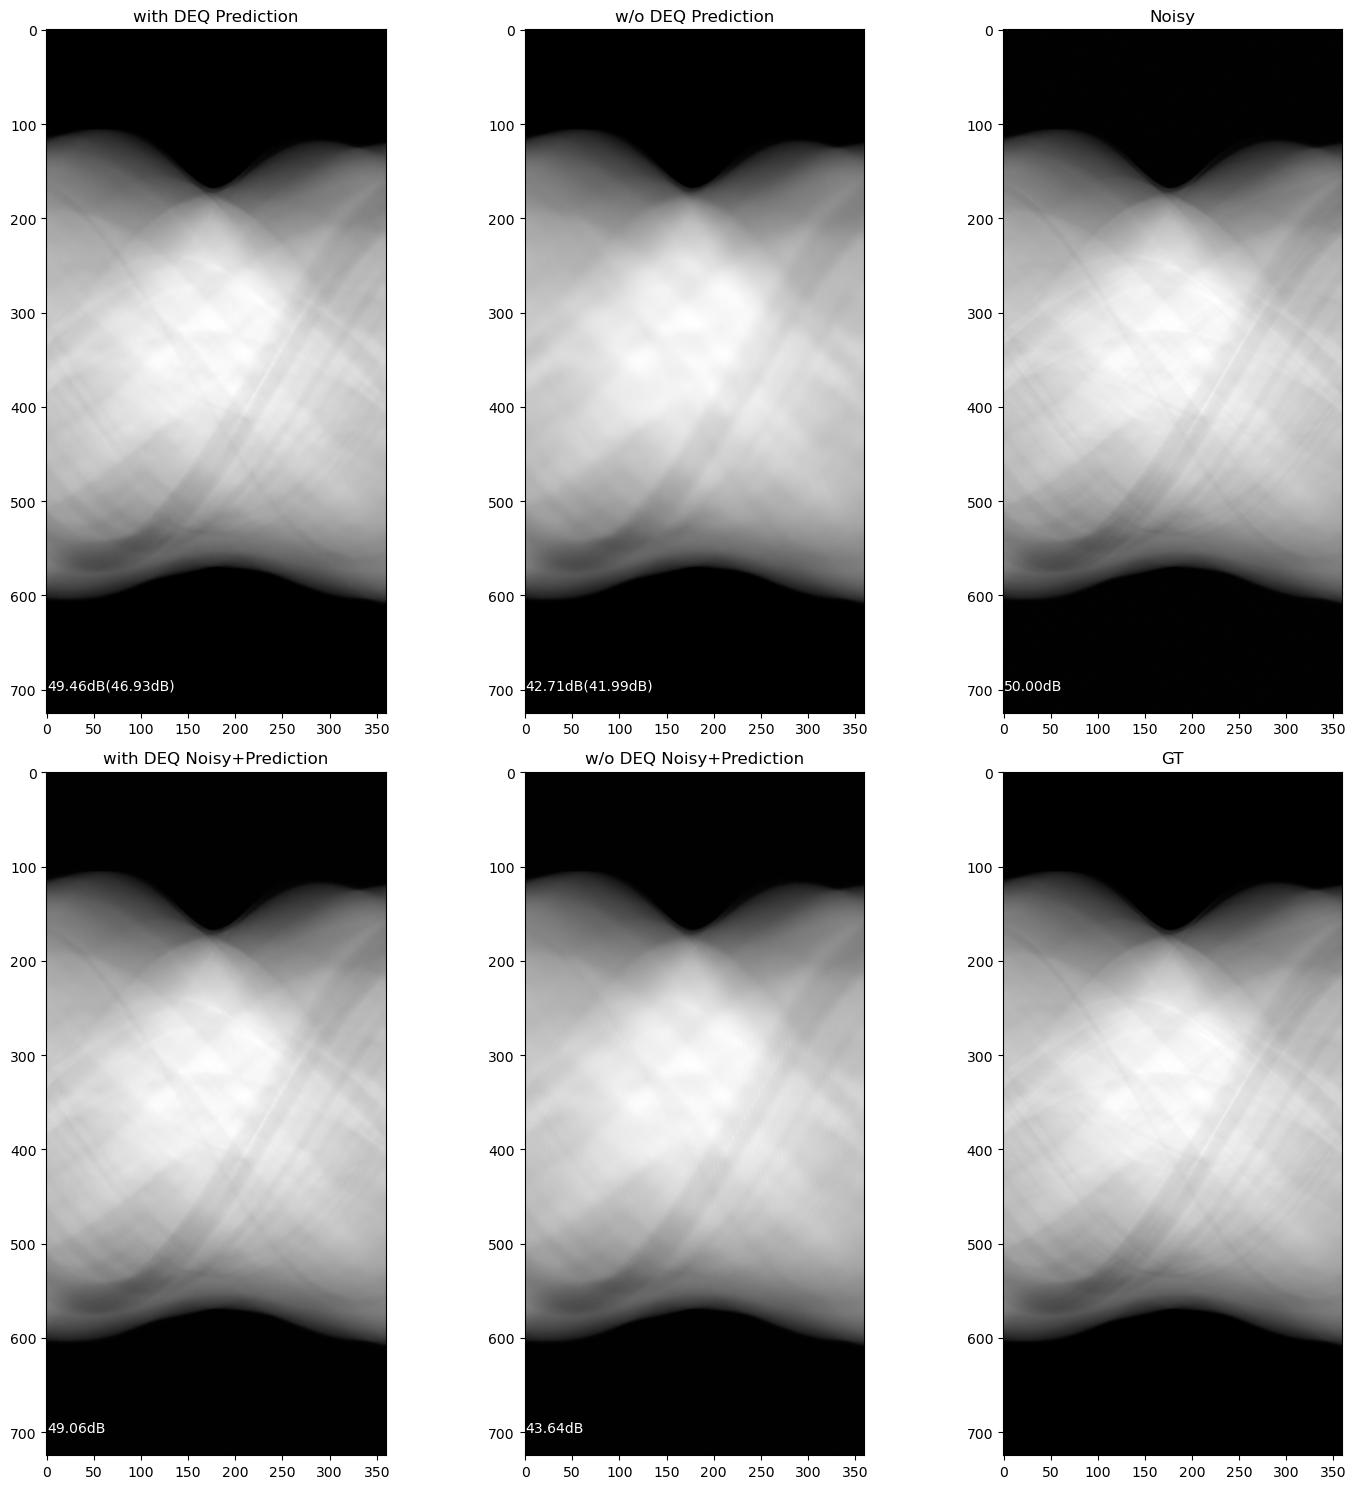

In [15]:
fig,axs=plt.subplots(2,3,figsize=(15,15),dpi=100)
axs[0][0].imshow(pred.reshape(-1,360),cmap='gray')
axs[0][0].set_title('with DEQ Prediction')
axs[0][0].text(0,700,f'{sino360PredGTSNR:.2f}dB({sino360PredNoisySNR:.2f}dB)',color='white',fontsize='medium')
axs[0][1].imshow(pred2.reshape(-1,360),cmap='gray')
axs[0][1].set_title('w/o DEQ Prediction')
axs[0][1].text(0,700,f'{sino360PredGTSNR2:.2f}dB({sino360PredNoisySNR2:.2f}dB)',color='white',fontsize='medium')
axs[0][2].imshow(fully.reshape(-1,360),cmap='gray')
axs[0][2].set_title('Noisy')
axs[0][2].text(0,700,f'{sino360NoisyGTSNR:.2f}dB',color='white',fontsize='medium')
axs[1][0].imshow(predNoisySino.reshape(-1,360),cmap='gray')
axs[1][0].set_title('with DEQ Noisy+Prediction')
axs[1][0].text(0,700,f'{sino360PNGTSNR:.2f}dB',color='white',fontsize='medium')
axs[1][1].imshow(predNoisySino2.reshape(-1,360),cmap='gray')
axs[1][1].set_title('w/o DEQ Noisy+Prediction')
axs[1][1].text(0,700,f'{sino360PNGTSNR2:.2f}dB',color='white',fontsize='medium')
axs[1][2].imshow(gty.reshape(-1,360),cmap='gray')
axs[1][2].set_title('GT')
fig.tight_layout()
plt.show()

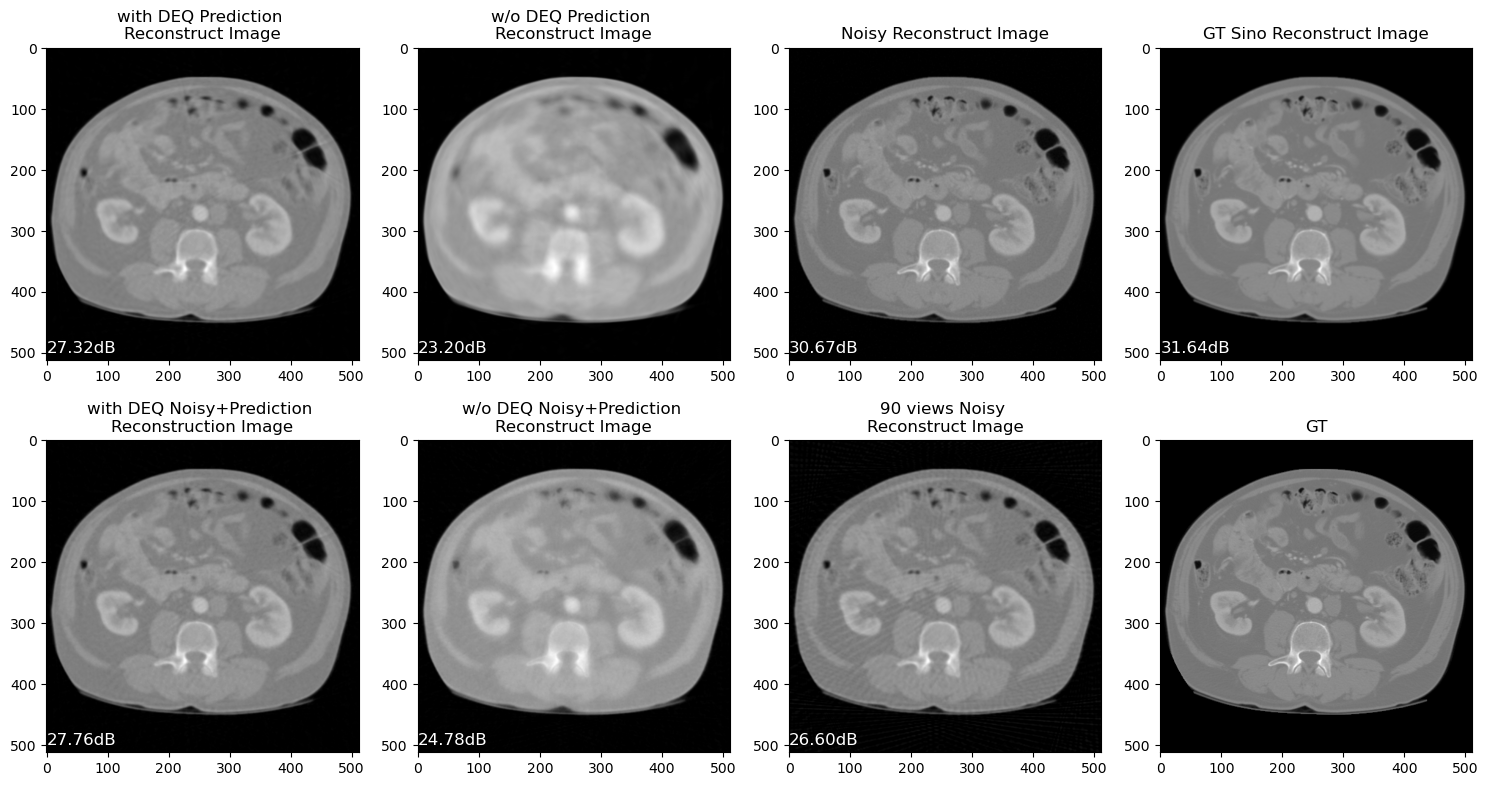

In [27]:
fig,axs=plt.subplots(2,4,figsize=(15,8),dpi=100)

axs[0][0].imshow(pred360ReconImage.reshape(512,512),cmap='gray')
axs[0][0].set_title('with DEQ Prediction \nReconstruct Image')
axs[0][0].text(0,500,f'{pred360ReconSNR:.2f}dB',color='white',fontsize='large')
axs[1][0].imshow(predNoisyReconImage.reshape(512,512),cmap='gray')
axs[1][0].set_title('with DEQ Noisy+Prediction \nReconstruction Image')
axs[1][0].text(0,500,f'{PNReconSNR:.2f}dB',color='white',fontsize='large')
axs[0][2].imshow(noisy360ReconImage.reshape(512,512),cmap='gray')
axs[0][2].set_title('Noisy Reconstruct Image')
axs[0][2].text(0,500,f'{noisy360ReconSNR:.2f}dB',color='white',fontsize='large')
axs[0][1].imshow(pred360ReconImage2.reshape(512,512),cmap='gray')
axs[0][1].set_title('w/o DEQ Prediction \nReconstruct Image')
axs[0][1].text(0,500,f'{pred360ReconSNR2:.2f}dB',color='white',fontsize='large')
axs[1][1].imshow(predNoisyReconImage2.reshape(512,512),cmap='gray')
axs[1][1].set_title('w/o DEQ Noisy+Prediction \nReconstruct Image')
axs[1][1].text(0,500,f'{PNReconSNR2:.2f}dB',color='white',fontsize='large')
axs[0][3].imshow(GT360ReconImage.reshape(512,512),cmap='gray')
axs[0][3].set_title('GT Sino Reconstruct Image')
axs[0][3].text(0,500,f'{GT360ReconSNR:.2f}dB',color='white',fontsize='large')
axs[1][2].imshow(noisy90ReconImage.reshape(512,512),cmap='gray')
axs[1][2].set_title('90 views Noisy \nReconstruct Image')
axs[1][2].text(0,500,f'{noisy90ReconSNR:.2f}dB',color='white',fontsize='large')
axs[1][3].imshow(image,cmap='gray')
axs[1][3].set_title('GT')
fig.tight_layout()

plt.show()